In [23]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sns
from itertools import product

In [24]:
data = pd.read_csv('m_returns.csv', index_col = 'date')
data.head()

,SPX,EEM,XAU,USTTEN,USDCOP
date,,,,,
2011-02-14,0.046434,-0.057770,-0.038196,-0.021115,0.007020
2011-02-15,0.044507,-0.060353,-0.004829,-0.020181,0.011852
2011-02-16,0.045751,-0.049548,-0.002805,-0.010126,0.019702
2011-02-17,0.050947,-0.035324,0.009087,-0.012194,0.015859
2011-02-18,0.054716,-0.020095,0.014822,-0.018477,0.006955


In [25]:
# set number of assets (= number of qubits)
num_assets = data.shape[1] - 1
seed = 123

In [26]:
# set number of assets (= number of qubits)
mu = data.mean().values
sigma = data.cov().values


In [27]:
# Verifica si la matriz de covarianzas es simétrica
is_symmetric = np.allclose(sigma, sigma.T)

# Verifica si todos los autovalores son no negativos
eigenvalues, _ = np.linalg.eig(sigma)
is_positive_semidefinite = np.all(eigenvalues >= 0)

if is_symmetric and is_positive_semidefinite:
    print("La matriz de covarianzas es positiva semidefinida.")
else:
    print("La matriz de covarianzas no es positiva semidefinida.")


La matriz de covarianzas es positiva semidefinida.


In [28]:
column_names = data.columns
sigma_df = pd.DataFrame(sigma, columns=column_names, index=column_names)
sigma_df.round(3)

,SPX,EEM,XAU,USTTEN,USDCOP
SPX,0.003,0.002,0.000,-0.000,-0.001
EEM,0.002,0.004,0.001,-0.000,-0.002
XAU,0.000,0.001,0.002,0.000,-0.001
USTTEN,-0.000,-0.000,0.000,0.001,0.000
USDCOP,-0.001,-0.002,-0.001,0.000,0.002


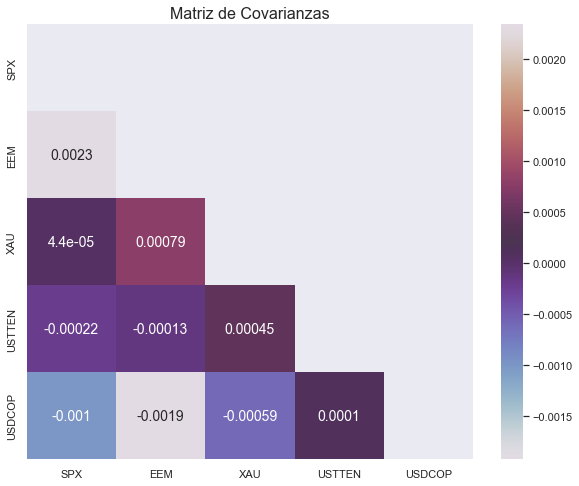

In [29]:
plt.figure(figsize = (10,8))
sns.set(font_scale=1)
mask = np.zeros_like(sigma_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(sigma_df,annot=True,cmap='twilight',annot_kws={"size":14}, square = False, mask = mask, alpha = 0.85)
plt.title('Matriz de Covarianzas', fontsize=16)
plt.show()

In [30]:
q = 0.5  # set risk factor
budget = num_assets // 1 # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0012651017811520443*x_0^2 + 0.002338940543495318..., 5 variables, 1 constraints, 'Portfolio optimization'>

In [31]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [32]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 1. 1.], value -0.0162

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 1 1]	-0.0162		1.0000


# VQE

In [33]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=10000)
ry = TwoLocal(num_assets, "ry", "cz", reps = 3, entanglement = "full")
vqe_mes = SamplingVQE(sampler = Sampler(), ansatz = ry, optimizer = cobyla)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

KeyboardInterrupt: 

# QAOA

In [ ]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=10000)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 1. 1.], value -0.0162

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 1 1]	-0.0026		0.1582
[1 1 1 0 1]	-0.0109		0.1533
[1 1 0 1 1]	-0.0099		0.1514
[1 1 1 1 0]	-0.0046		0.1426
[1 0 1 1 1]	-0.0162		0.1240
[1 1 1 1 1]	-0.0111		0.0967
[0 1 0 1 1]	-0.0014		0.0166
[1 0 1 1 0]	-0.0116		0.0166
[1 0 0 1 1]	-0.0142		0.0156
[1 1 0 0 1]	-0.0093		0.0127
[0 1 1 0 1]	-0.0026		0.0127
[1 1 0 1 0]	-0.0040		0.0117
[0 1 1 1 0]	0.0029		0.0117
[0 0 1 1 1]	-0.0054		0.0117
[1 0 1 0 1]	-0.0161		0.0117
[1 1 1 0 0]	-0.0043		0.0088
[0 0 0 0 1]	-0.0031		0.0078
[0 0 0 1 0]	-0.0004		0.0068
[1 0 0 0 0]	-0.0096		0.0049
[0 1 0 0 0]	0.0040		0.0039
[0 1 1 0 0]	0.0030		0.0039
[1 0 0 0 1]	-0.0137		0.0029
[0 0 1 0 0]	-0.0018		0.0029
[1 0 1 0 0]	-0.0114		0.0020
[0 0 0 1 1]	-0.0034		0.0020
[0 0 0 0 0]	0.0000		0.0020
[1 0 0 1 0]	-0.0103		0.0010
[1 1 0 0 0]	-0.0033		0.0010
[0 1 0 1 0]	0.0035		0.0010
[0 0 1 1

In [ ]:
# from qiskit import Aer
# from qiskit.optimization import QuadraticProgram
# from qiskit.aqua import QuantumInstance
# from qiskit.aqua.algorithms import VQE
# from qiskit.aqua.components.optimizers import COBYLA
# from qiskit.aqua.components.variational_forms import RY
# from qiskit.optimization.algorithms import MinimumEigenOptimizer

# Supongamos que tienes un objeto QuadraticProgram llamado 'qp' que define el problema QUBO.
algorithm_globals.random_seed = 1234
# Configura el optimizador clásico COBYLA
cobyla = COBYLA()
cobyla.set_options(maxiter=10000)

# Configura el ansatz cuántico (RY) y el algoritmo VQE
num_assets = len(qp.variables)
ry = TwoLocal(num_assets, "ry", "cz", reps = 3, entanglement = "full")
#ry = RY(num_assets, entanglement="full")
vqe_mes = SamplingVQE(sampler = Sampler(), ansatz = ry, optimizer = cobyla)
#vqe = VQE(ry, optimizer=cobyla)

# Configura el MinimumEigenOptimizer para resolver el QUBO
qubo_optimizer = MinimumEigenOptimizer(vqe_mes)

# Resuelve el problema QUBO utilizando α-VQE
alpha = 0.2  # El valor de α, ajusta según tus necesidades
result = qubo_optimizer.solve(qp) #cva_risk_alpha=alpha)

# Imprime la solución
print(result)


fval=-0.01616772426112494, x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=1.0, status=SUCCESS


## QAOA Portfolios

In [34]:
prs = pd.read_csv('probs.csv',index_col=0)
prtest = prs.loc['2020-10':,:]
r_ = pd.read_csv('m_returns.csv',index_col=0)
r_ =  r_.add(1).apply(np.log)

In [44]:
ws_qaoa = []

for i in prtest.index:
    rr = r_.loc[:i, :].iloc[-252*5:, :]
    m_ = rr.median().mul(12).mul(100)
    m_.loc['SPX'] = m_.loc['SPX'] + 1.5  # DIV YIELD
    m_.loc['EEM'] = m_.loc['EEM'] + 3  # DIV YIELD
    
    corr_ = rr.corr()
    vol_ = rr.std().mul(np.sqrt(12)).mul(100)
    corr_ = pd.DataFrame(corr_.values, columns=vol_.values, index=vol_.values)
    sigma_ = corr_.copy()

    for ix, jx in product(vol_, repeat=2):
        sigma_.loc[ix, jx] = corr_.loc[ix, jx] * ix * jx

    expected_returns = m_.values.tolist()
    covariances = sigma_.values.tolist()

    budget = 4
    
    # Optimización con QAOA
    portfolio = PortfolioOptimization(expected_returns=expected_returns, covariances=covariances, risk_factor=0.5, budget=budget)
    qp = portfolio.to_quadratic_program()
    
    algorithm_globals.random_seed = 1234
    cobyla = COBYLA()
    cobyla.set_options(maxiter=10000)
    qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)

    wqaoa = result.x
    ws_qaoa.append(wqaoa)

ws_qaoa = pd.DataFrame(ws_qaoa, index=pd.to_datetime(prtest.index))
ws_qaoa.columns = r_.columns

ws_qaoa = ws_qaoa.replace(1, 1/3)

,SPX,EEM,XAU,USTTEN,USDCOP
date,,,,,
2020-10-07,1.0,0.0,1.0,1.0,1.0
2020-10-14,1.0,0.0,1.0,1.0,1.0
2020-10-21,1.0,0.0,1.0,1.0,1.0
2020-10-28,1.0,0.0,1.0,1.0,1.0
2020-11-04,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...
2023-09-27,1.0,0.0,1.0,1.0,1.0
2023-10-04,1.0,0.0,1.0,1.0,1.0
2023-10-11,0.0,1.0,1.0,1.0,1.0


In [46]:
ws_qaoa.head()

In [52]:
#optim
def mvo(r,covar,vx,x0,bnds):
    rr =r.values
    def w(x):
        return np.sum(x[:4])-1
    def varp(x):
        return np.dot(np.matmul(x,covar),x)-vx**2
    def rfun(x):
        return -np.dot(x,rr)
    cons  = [{'type': 'eq', 'fun': varp},{'type': 'eq', 'fun': w}]
    res = minimize(rfun,x0,bounds=bnds,constraints=cons)

    return  -rfun(res.x), pd.Series(res.x,index=r.index)



def BLopt(r,sigma,q,c,tau=0.025):
    pick = pick = np.eye(len(r))
    PEP = np.matmul(np.matmul(pick,sigma),pick.T)
    v = r + np.diag(sigma**(1/2))*q # r + 2(pr-0.5)*vol
    omega = (c@PEP)@c
    mu_bl = r + tau*np.matmul(np.matmul(sigma*pick.T,inv(tau*PEP+omega)),v-np.matmul(pick,r))
    sigma_bl = (1+tau)*sigma - tau**2*np.matmul(np.matmul(np.matmul(sigma,pick.T),inv(tau*PEP+omega)),np.matmul(pick,sigma))

    return pd.Series(mu_bl,index=r.index),sigma_bl,v,omega

In [55]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from itertools import product
from numpy.linalg import cholesky, inv
import plotly.graph_objs as go
import plotly.offline as po

In [53]:
x0 = [0.25,0.25,0.25,0.25,0.25]
bnds = ((0, 1), (0, 1),(0, 1),(0, 1),(-0.5, 1.5))
vx = 10
coef_conv = 2

In [61]:
ws_=[]
wseq=[]
wsv= []
wqaoam = []
for i in prtest.index:
    rr = r_.loc[:i,:].iloc[-252*5:,:]
    m_ = rr.median().mul(12).mul(100)
    m_.loc['SPX'] = m_.loc['SPX'] +1.5 #DIV YIELD
    m_.loc['EEM'] = m_.loc['EEM'] +3 # DIV YIELD
    corr_ = rr.corr()
    vol_ = rr.std().mul(np.sqrt(12)).mul(100)
    corr_ = pd.DataFrame(corr_.values,columns=vol_.values,index=vol_.values)
    sigma_ = corr_.copy()

    for ix,jx in product(vol_,repeat=2):
        sigma_.loc[ix,jx] = corr_.loc[ix,jx]*ix*jx

    req,weq =mvo(m_,sigma_,vx,x0,bnds)
    wseq.append(weq)
    c = 1/(np.sqrt([(pr -0.5)**2 for pr in prtest.loc[i,:]])*coef_conv)
    q = [2*(pr -0.5) for pr in prtest.loc[i,:]]
    mu_bl,sigma_bl,v,omega = BLopt(m_,sigma_.values,q,c)
    rbl,wbl = mvo(mu_bl,sigma_bl,vx,x0,bnds)

    ws_.append(wbl)
    rv,wv = mvo(v,sigma_,vx,x0,bnds)
    wsv.append(wv)
    
    expected_returns = v.tolist()
    covariances = sigma_.values.tolist()
    
    budget = 4
    
    # Optimización con QAOA
    portfolio = PortfolioOptimization(expected_returns=expected_returns, covariances=covariances, risk_factor=0.5, budget=budget)
    qp = portfolio.to_quadratic_program()
    
    algorithm_globals.random_seed = 1234
    cobyla = COBYLA()
    cobyla.set_options(maxiter=10000)
    qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)

    wqaoam_i = result.x
    wqaoam.append(wqaoam_i)

wqaoam = pd.DataFrame(wqaoam, index=pd.to_datetime(prtest.index))
wqaoam.columns = r_.columns

wqaoam = wqaoam.replace(1, 1/3)

ws_ = pd.concat(ws_,axis=1).transpose()
ws_.index= pd.to_datetime(prtest.index)

wseq = pd.concat(wseq,axis=1).transpose()
wseq.index= pd.to_datetime(prtest.index)

wsv = pd.concat(wsv,axis=1).transpose()
wsv.index= pd.to_datetime(prtest.index)

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt



C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\622302400.py:20: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\maria\AppData\Local\Temp\ipykernel_8408\6223024

In [62]:
wqaoam

,SPX,EEM,XAU,USTTEN,USDCOP
date,,,,,
2020-10-07,0.333333,0.000000,0.333333,0.333333,0.333333
2020-10-14,0.333333,0.000000,0.333333,0.333333,0.333333
2020-10-21,0.333333,0.000000,0.333333,0.333333,0.333333
2020-10-28,0.333333,0.000000,0.333333,0.333333,0.333333
2020-11-04,0.333333,0.000000,0.333333,0.333333,0.333333
...,...,...,...,...,...
2023-09-27,0.333333,0.000000,0.333333,0.333333,0.333333
2023-10-04,0.333333,0.000000,0.333333,0.333333,0.333333
2023-10-11,0.000000,0.333333,0.333333,0.333333,0.333333


In [63]:
comparison_result = (wqaoam  == ws_qaoa)

In [65]:
comparison_result.to_csv('comparison.csv')